In [1]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl"
import pyrender
import cv2
import glob
import json
import time
import trimesh
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=3)
from scipy.spatial.transform import Rotation as R
from inference.utils.camera_utils import load_camera_params
from inference.process_pose import PoseEstimator, PoseEstimatorParams
from utils.data_utils import Capture, render_mask
import utils.data_utils as du
import importlib
importlib.reload(du)

<module 'utils.data_utils' from '/ipd_codebase/utils/data_utils.py'>

Loading camera parameters from: ./datasets/ipd/test/000000/scene_camera_cam3.json
[array([[    0.16109,   -0.019536,     0.98675,       76.14],
       [    0.98432,    0.076034,    -0.15919,      15.284],
       [  -0.071916,     0.99691,    0.031478,      1737.9],
       [          0,           0,           0,           1]]), array([[   -0.80854,   -0.082814,     0.58259,      77.276],
       [   -0.58577,    0.019053,    -0.81025,      184.78],
       [      0.056,    -0.99638,   -0.063916,      1722.3],
       [          0,           0,           0,           1]]), array([[    0.65702,    0.050518,     0.75218,      112.43],
       [   -0.74703,   -0.090515,      0.6586,      74.563],
       [    0.10135,    -0.99461,   -0.021733,      1733.7],
       [          0,           0,           0,           1]]), array([[    0.87979,     0.41594,     0.23014,      162.08],
       [   -0.46985,     0.68742,     0.55379,      178.76],
       [   0.072141,    -0.59535,     0.80022,      1720.

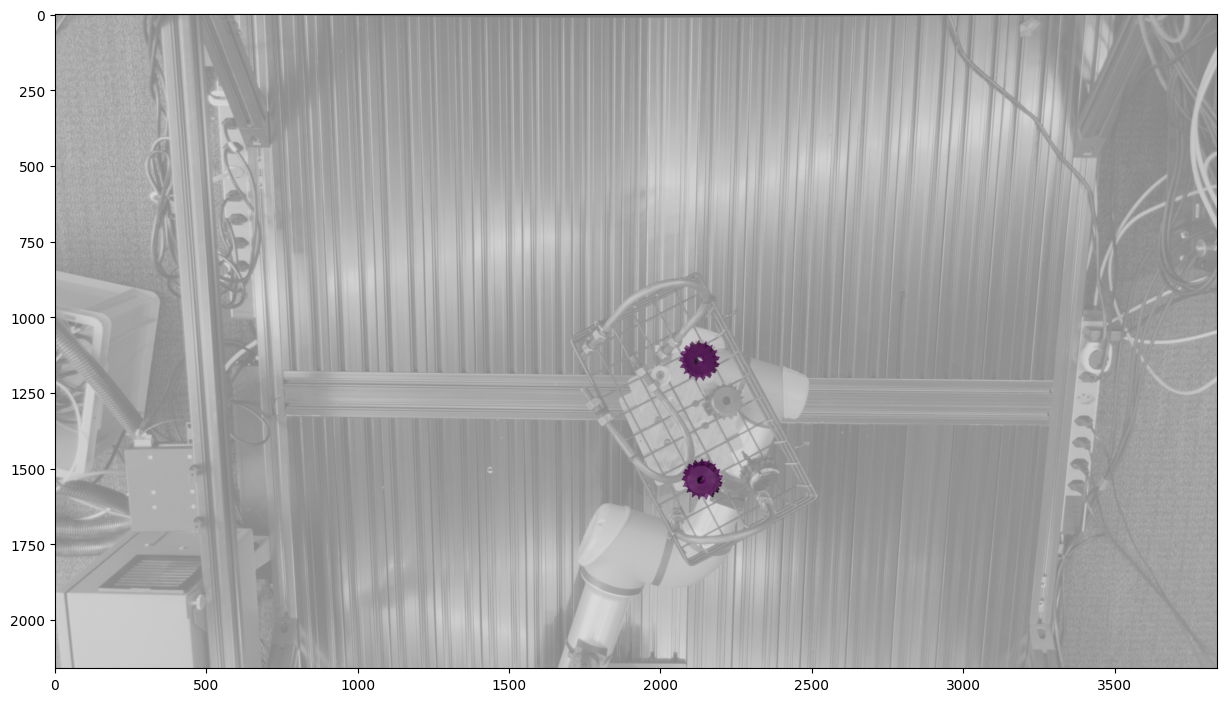

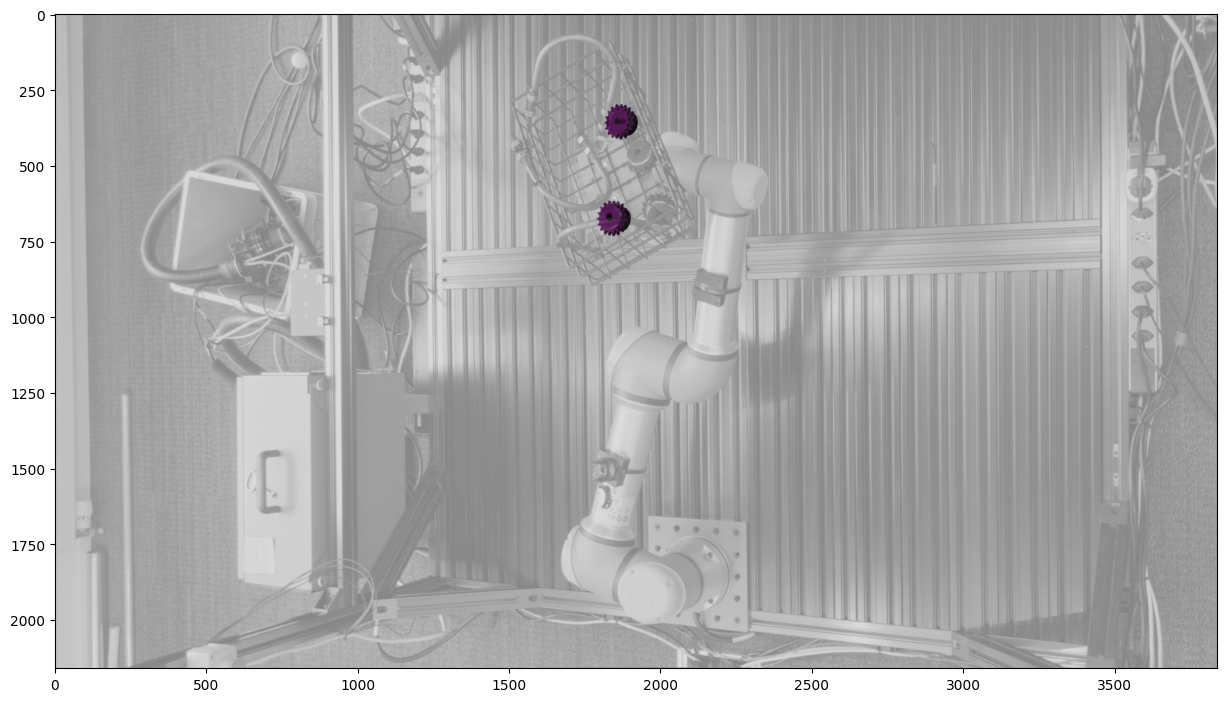

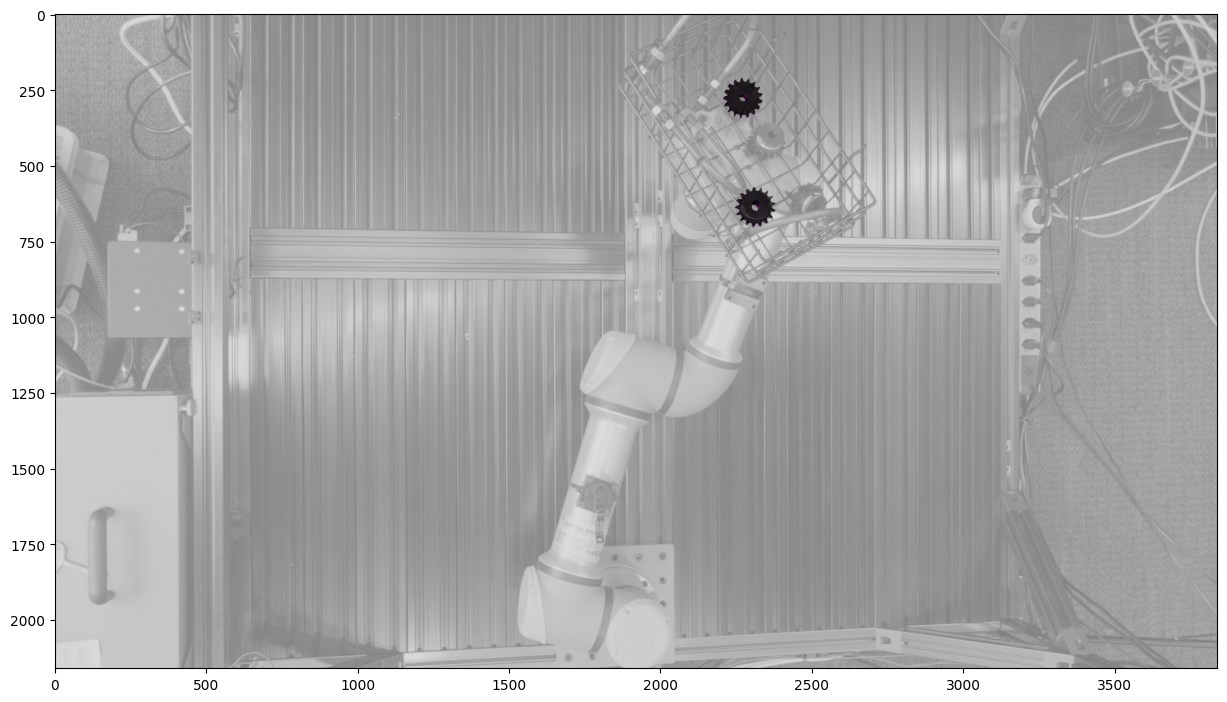

In [16]:
# scene_dir = "./datasets/ipd_bop_data_jan25_1/train_pbr/000000/"
# models_dir = './datasets/ipd_bop_data_jan25_1/models_eval/'
scene_dir = "./datasets/ipd/test/000000/"
models_dir = './datasets/ipd/models/'
cam_ids = ["cam1", "cam2", "cam3"]
image_id = 3
obj_id = 8
obj_id_path = str(1000000+obj_id)[1:]
ply_file = os.path.join(models_dir, f"obj_{obj_id_path}.ply")
obj = trimesh.load(ply_file)
yolo_model_path = f'models/detection/obj_{obj_id}/yolo11-detection-obj_{obj_id}.pt'
pose_model_path = f'models/rot_models/rot_{obj_id}.pth'

pose_params = PoseEstimatorParams(yolo_model_path=yolo_model_path,
                                  pose_model_path=pose_model_path, 
                                  yolo_conf_thresh=0.01)
pose_estimator = PoseEstimator(pose_params)
t = time.time()
capture = Capture.from_dir(scene_dir, cam_ids, image_id, obj_id)
detections = pose_estimator._detect(capture)
pose_predictions = pose_estimator._match(capture, detections)
pose_estimator._estimate_rotation(pose_predictions)
print(time.time() - t)

for idx in range(len(capture.Ks)):
    plt.figure(figsize=(15, 15))
    plt.imshow(capture.images[idx])
    a, b = render_mask(obj, capture.Ks[idx], (capture.RTs[idx]), capture.images[0].shape[:2][::-1], [x.pose for x in pose_predictions])
    plt.imshow(a, alpha=0.5)
    plt.show()


In [14]:
t = time.time()
capture = Capture.from_dir(scene_dir, cam_ids, image_id, obj_id)
detections = pose_estimator._detect(capture)
pose_predictions = pose_estimator._match(capture, detections)
pose_estimator._estimate_rotation(pose_predictions)
print(time.time() - t)


Loading camera parameters from: ./datasets/ipd/test/000000/scene_camera_cam3.json
[array([[     0.6082,    -0.30884,    -0.73124,      120.44],
       [    -0.7646,    0.019554,    -0.64421,      174.99],
       [    0.21325,     0.95091,    -0.22425,      1712.4],
       [          0,           0,           0,           1]]), array([[   0.073209,     0.43761,    -0.89618,      242.83],
       [    0.99681,  -0.0034893,    0.079726,      63.347],
       [   0.031761,    -0.89916,    -0.43647,      1751.6],
       [          0,           0,           0,           1]]), array([[   -0.96034,     0.27883, -0.00087327,      140.61],
       [ -0.0088349,   -0.033559,     -0.9994,      108.76],
       [   -0.27869,    -0.95975,    0.034691,      1719.9],
       [          0,           0,           0,           1]]), array([[   -0.89528,      0.4416,   -0.058921,       186.9],
       [   -0.35931,     -0.7939,    -0.49052,      2.7757],
       [   -0.26339,    -0.41798,     0.86943,      1730.

In [4]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.transform import Rotation as R  # For rotation handling
threshold = 30

T_shift = np.eye(4)
T_shift[:3, 3] = np.mean(obj.bounds, axis=0)
gt_translations = np.array([x@T_shift for x in capture.gt_poses])[:,:3, 3]  # Nx3
gt_rotations = np.array([x@T_shift for x in capture.gt_poses])[:,:3,:3]  # Nx3x3
predicted_translations = np.array([p.t for p in pose_predictions])  # Mx3
predicted_rotations = np.array([p.final_rotation for p in pose_predictions])  # Mx3x3

N = gt_translations.shape[0]
M = predicted_translations.shape[0]

# Vectorized cost matrix calculation (for translation)
cost_matrix = np.linalg.norm(gt_translations[:, np.newaxis,:] - predicted_translations[np.newaxis,:,:], axis=2)

# Use linear_sum_assignment to find the optimal assignment (based on translation)
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Calculate translation errors based on the optimal assignment
translation_errors = cost_matrix[row_ind, col_ind]

# Calculate rotation errors (geodesic distance)
rotation_errors = np.zeros(N)
for i in range(len(row_ind)):
    gt_rotation = R.from_matrix(gt_rotations[row_ind[i]])
    predicted_rotation = R.from_matrix(predicted_rotations[col_ind[i]])

    # Alternative geodesic distance calculation (for SciPy < 1.7.0)
    rel_rot = gt_rotation.inv() * predicted_rotation
    print(rel_rot.magnitude()*180/3.14)
# True Positives (using translation errors)
true_positives = np.sum(translation_errors < threshold)

# Precision and Recall (using translation)
if M > 0:  # Avoid division by zero if no predictions
    precision = true_positives / M
else:
    precision = 0.0

if N > 0: # Avoid division by zero if no ground truths
    recall = true_positives / N
else:
    recall = 0.0

# Report the results
print(f"True Positives: {true_positives}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Average Translation Error: {np.mean(translation_errors)}")
print(f"Average Rotation Error: {np.mean(rotation_errors)}")

# Closest predicted translations
closest_predicted_translations = predicted_translations[col_ind]
closest_predicted_rotations = predicted_rotations[col_ind] #Closest predicted rotation


29.993209872739914
True Positives: 1
Precision: 1.0
Recall: 0.5
Average Translation Error: 21.136611816949575
Average Rotation Error: 0.0


In [5]:


        

detections = pose_estimator._detect(capture)


0: 736x1280 4 object_11s, 8.7ms
Speed: 6.9ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 4 object_11s, 8.5ms
Speed: 7.3ms preprocess, 8.5ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 5 object_11s, 8.4ms
Speed: 6.3ms preprocess, 8.4ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)


0

0: 736x1280 3 object_8s, 10.4ms
Speed: 7.0ms preprocess, 10.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


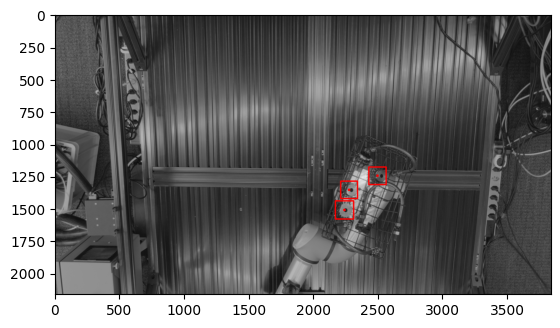

1

0: 736x1280 4 object_8s, 9.8ms
Speed: 8.5ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


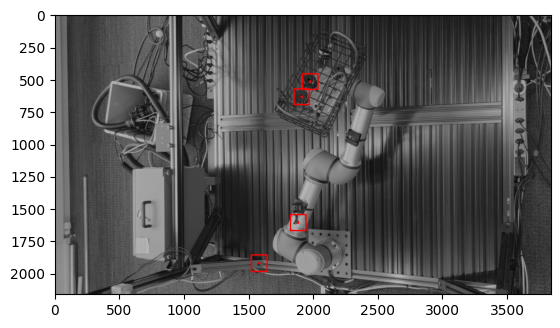

2

0: 736x1280 4 object_8s, 9.4ms
Speed: 6.8ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


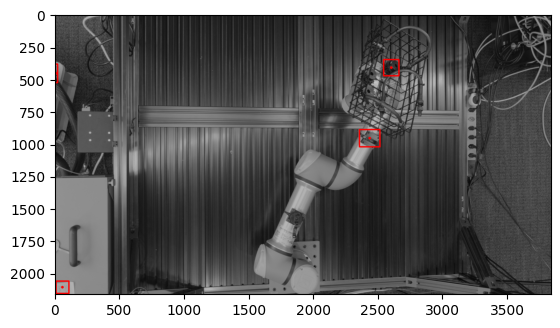

{0: [{'bbox': (2166, 1441, 2307, 1581), 'bb_center': (2236.5, 1511.0)},
  {'bbox': (2207, 1289, 2337, 1423), 'bb_center': (2272.0, 1356.0)},
  {'bbox': (2424, 1180, 2558, 1315), 'bb_center': (2491.0, 1247.5)}],
 1: [{'bbox': (1847, 577, 1965, 698), 'bb_center': (1906.0, 637.5)},
  {'bbox': (1911, 461, 2031, 581), 'bb_center': (1971.0, 521.0)},
  {'bbox': (1819, 1547, 1938, 1670), 'bb_center': (1878.5, 1608.5)},
  {'bbox': (1517, 1858, 1639, 1986), 'bb_center': (1578.0, 1922.0)}],
 2: [{'bbox': (8, 2060, 107, 2155), 'bb_center': (57.5, 2107.5)},
  {'bbox': (2352, 891, 2510, 1024), 'bb_center': (2431.0, 957.5)},
  {'bbox': (2539, 351, 2657, 476), 'bb_center': (2598.0, 413.5)},
  {'bbox': (0, 386, 20, 529), 'bb_center': (10.0, 457.5)}]}

In [15]:
def _detect(self, capture):
    camera_predictions = {}
    for idx, image in enumerate(capture.images):
        print(idx)
        vis = image.copy()
        detections = self.yolo(image, imgsz=1280)[0]
        boxes = detections.boxes.xyxy.cpu().numpy()
        confs = detections.boxes.conf.cpu().numpy()
        clss  = detections.boxes.cls.cpu().numpy()
        if len(detections.boxes)==0:
            camera_predictions[cam_id] = []
            continue
        # Keep only class=0 with conf>=0.5
        valid = (clss==0) & (confs>=0.1)
        boxes = boxes[valid]
        preds_cam = []
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            cx = 0.5*(x1 + x2)
            cy = 0.5*(y1 + y2)

            preds_cam.append({
                'bbox': (x1, y1, x2, y2),
                'bb_center': (cx, cy),
            })
            cv2.rectangle(vis, (x1, y1), (x2, y2), 255, thickness=10)
            cv2.circle(vis, (int(cx), int(cy)), 5, 255, thickness=10)

        plt.imshow(vis)
        plt.show()

        camera_predictions[idx] = preds_cam
    return camera_predictions
        

_detect(pose_estimator, capture)

In [7]:
# def _detect_gt(self, capture):
#     camera_predictions = {}
#     for idx, image in enumerate(capture.images):
#         vis = image.copy()
#         preds_cam = []
#         K, RT = capture.Ks[idx], (capture.RTs[idx])
#         print(RT)
#         mesh_poses = np.array([(RT @ x) for x in capture.gt_poses])
#         verts = 0*obj.vertices[:1][None] @ mesh_poses[:, :3, :3].transpose((0, 2, 1)) + mesh_poses[:, :3, 3:].transpose((0, 2, 1))
#         print(mesh_poses)
#         verts = verts.reshape(-1, 3)
#         print(verts)
#         centroids = cv2.projectPoints(verts, np.eye(3), np.zeros((3, 1)), K, None)[0][:, 0].astype(int)
#         for cx, cy in centroids:

#             preds_cam.append({
#                 'bbox': (cx, cy, cx, cy),
#                 'bb_center': (cx, cy),
#             })
#             cv2.circle(vis, (int(cx), int(cy)), 5, 255, thickness=10)

#         plt.imshow(vis)
#         plt.show()

#         camera_predictions[idx] = preds_cam
#     return camera_predictions


# detections_gt = _detect_gt(pose_estimator, capture)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2  # For image drawing (optional, but recommended)






matches = _match(pose_estimator, capture, detections)


NameError: name '_match' is not defined

In [ ]:
predicted_translations

In [ ]:
gt_translations